# Problem 1

Consider a 2D robotic arm with 3 links. The position of its end-effector is governed by the arm lengths and joint angles as follows (as in the figure "data/robot-arm.png"):
$$
x = L_1 \cos(\theta_1) + L_2\cos(\theta_2+\theta_1) + L_3\cos(\theta_3+\theta_2+\theta_1)\\
y = L_1\sin(\theta_1) + L_2\sin(\theta_2+\theta_1) + L_3\sin(\theta_3+\theta_2+\theta_1)
$$

In robotics settings, inverse-kinematics problems are common for setups like this. For example, suppose all 3 arm lengths are $L_1 = L_2 = L_3 = 1$, and we want to position the end-effector at $(x,y) = (0.5, 0.5)$. What set of joint angles $(\theta_1, \theta_2, \theta_3)$ should we choose for the end-effector to reach this position?

In this problem you will train a neural network to find a function mapping from coordinates $(x,y)$ to joint angles $(\theta_1, \theta_2, \theta_3)$ that position the end-effector at $(x,y)$.



#### Summary of deliverables:

1. Neural network model

2. Generate training and validation data

3. Training function

4. 6 plots with training and validation loss

5. 6 prediction plots

6. Respond to the prompts


In [13]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim

class ForwardArm(nn.Module):
    def __init__(self, L1=1, L2=1, L3=1):
        super().__init__()
        self.L1 = L1
        self.L2 = L2
        self.L3 = L3
    def forward(self, angles):
        theta1 = angles[:,0]
        theta2 = angles[:,1]
        theta3 = angles[:,2]
        x = self.L1*torch.cos(theta1) + self.L2*torch.cos(theta1+theta2) + self.L3*torch.cos(theta1+theta2+theta3)
        y = self.L1*torch.sin(theta1) + self.L2*torch.sin(theta1+theta2) + self.L3*torch.sin(theta1+theta2+theta3)
        return torch.vstack([x,y]).T

def plot_predictions(model, title=""):
    fwd = ForwardArm()

    vals = np.arange(0.1, 2.0, 0.2)
    x, y = np.meshgrid(vals,vals)
    coords = torch.tensor(np.vstack([x.flatten(),y.flatten()]).T,dtype=torch.float)
    angles = model(coords)
    preds = fwd(angles).detach().numpy()

    plt.figure(figsize=[4,4],dpi=140)

    plt.scatter(x.flatten(), y.flatten(), s=60, c="None",marker="o",edgecolors="k", label="Targets")
    plt.scatter(preds[:,0], preds[:,1], s=25, c="red", marker="o", label="Predictions")
    plt.text(0.1, 2.15, f"MSE = {nn.MSELoss()(fwd(model(coords)),coords):.1e}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim(-.1,2.1)
    plt.ylim(-.1,2.4)
    plt.legend()
    plt.title(title)
    plt.show()

def plot_arm(theta1, theta2, theta3, L1=1,L2=1,L3=1, show=True):
    x1 = L1*np.cos(theta1)
    y1 = L1*np.sin(theta1)
    x2 = x1 + L2*np.cos(theta1+theta2)
    y2 = y1 + L2*np.sin(theta1+theta2)
    x3 = x2 + L3*np.cos(theta1+theta2+theta3)
    y3 = y2 + L3*np.sin(theta1+theta2+theta3)
    xs = np.array([0,x1,x2,x3])
    ys = np.array([0,y1,y2,y3])

    plt.figure(figsize=(5,5),dpi=140)
    plt.plot(xs, ys, linewidth=3, markersize=5,color="gray", markerfacecolor="lightgray",marker="o",markeredgecolor="black")
    plt.scatter(x3,y3,s=50,color="blue",marker="P",zorder=100)
    plt.scatter(0,0,s=50,color="black",marker="s",zorder=-100)
    
    plt.xlim(-1.5,3.5)
    plt.ylim(-1.5,3.5)

    if show:
        plt.show()

## End-effector position

You can use the interactive figure below to visualize the robot arm.

In [14]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual, Layout, FloatSlider, Dropdown

def plot_unit_arm(theta1, theta2, theta3):
    plot_arm(theta1, theta2, theta3)

slider1 = FloatSlider(value=0, min=-np.pi*0.75, max=np.pi*0.75, step=np.pi/100, description='theta1',disabled=False,continuous_update=True,orientation='horizontal',readout=False,layout = Layout(width='550px'))
slider2 = FloatSlider(value=0, min=-np.pi*0.75, max=np.pi*0.75, step=np.pi/100, description='theta2',disabled=False,continuous_update=True,orientation='horizontal',readout=False,layout = Layout(width='550px'))
slider3 = FloatSlider(value=0, min=-np.pi*0.75, max=np.pi*0.75, step=np.pi/100, description='theta3',disabled=False,continuous_update=True,orientation='horizontal',readout=False,layout = Layout(width='550px'))

interactive_plot = interactive(plot_unit_arm, theta1 = slider1, theta2 = slider2, theta3 = slider3)
output = interactive_plot.children[-1]
output.layout.height = '600px'

interactive_plot

interactive(children=(FloatSlider(value=0.0, description='theta1', layout=Layout(width='550px'), max=2.3561944…

## Neural Network for Inverse Kinematics
In this class we have mainly had regression problems with only one output. However, you can create neural networks with any number of outputs just by changing the size of the last layer. For this problem, we already know the function to go from joint angles (3) to end-effector coordinates (2). This is provided in neural network format as `ForwardArm()`.

If you provide an instance of `ForwardArm()` with an $N\times3$ tensor of joint angles, and it will return an $N\times2$ tensor of coordinates.

Here, you should create a neural network with 2 inputs and 3 outputs that, once trained, can output the joint angles (in radians) necessary to reach the input x-y coordinates.

In the cell below, complete the definition for `InverseArm()`:
- The initialization argument `hidden_layer_sizes` dictates the number of neurons per hidden layer in the network. For example, `hidden_layer_sizes=[12,24]` should create a network with 2 inputs, 12 neurons in the first hidden layer, 24 neurons in the second hidden layer, and 3 outputs.
- Use a ReLU activation at the end of each hidden layer.
- The initialization argument `max_angle` refers to the maximum bend angle of the joint. If `max_angle=None`, there should be no activation at the last layer. However, if `max_angle=1` (for example), then the output joint angles should be restricted to the interval [-1, 1] (radians). You can clamp values with the tanh function (and then scale them) to achieve this.



In [15]:
class InverseArm(nn.Module):
    def __init__(self, hidden_layer_sizes=[24,24], max_angle=None):
        super().__init__()
        self.seq = nn.Sequential(
            nn.Linear(2,hidden_layer_sizes[0]),
        )
        for i in range(0,len(hidden_layer_sizes)-1):
            self.seq.append(nn.ReLU())
            self.seq.append(nn.Linear(hidden_layer_sizes[i], hidden_layer_sizes[i+1]))
        self.seq.append(nn.ReLU())
        self.seq.append(nn.Linear(hidden_layer_sizes[-1], 3))
        self.max_angle = max_angle
        if max_angle is not None:
            self.seq.append(nn.Tanh())
        
    def forward(self, xy):
        if self.max_angle is not None:
            return self.seq(xy) * self.max_angle
        return self.seq(xy)

## Generate Data

In the cell below, generate a dataset of x-y coordinates. You should use a $100\times 100$ meshgrid, for x and y each on the interval $[0, 2]$.  

Randomly split your data so that 80% of points are in `X_train`, while the remaining 20% are in `X_val`. (Each of these should have 2 columns -- x and y)

In [16]:
x,y = np.meshgrid(np.linspace(0,2,100),np.linspace(0,2,100))
x = x.reshape(-1,1)
y = y.reshape(-1,1)
N = x.shape[0]
idx = np.random.permutation(N)
X = np.concatenate([x,y], axis=1)
X_train = torch.Tensor(X[idx[:int(N*0.8)]])
X_val = torch.Tensor(X[idx[int(N*0.8):]])
print(f"X_train Size: {X_train.shape[0]}\t X_val Size: {X_val.shape[0]}")

X_train Size: 8000	 X_val Size: 2000


## Training function

Write a function `train()` below with the following specifications:

*Inputs:*  
- `model`: `InverseArm` model to train
- `X_train`: $N\times 2$ vector of training x-y coordinates
- `X_val`: $N\times 2$ vector of validation x-y coordinates
- `lr`: Learning rate for Adam optimizer
- `epochs`: Total epoch count
- `gamma`: ExponentialLR decay rate
- `create_plot`: (`True`/`False`) Whether to display a plot with training and validation loss curves

*Loss function:*  
The loss function you use should be based on whether the end-effector moves to the correct location. It should be the MSE between the target coordinate tensor and the coordinates that the predicted joint angles produce. In other words, if your inverse kinematics model is `model`, and `fwd` is an instance of `ForwardArm()`, then you want the MSE between input coordinates `X` and `fwd(model(X))`.


In [23]:
def plot_loss(train_loss, val_loss):
    plt.figure(figsize=(4,2),dpi=250)
    plt.plot(train_loss,label="Training")
    plt.plot(val_loss,label="Validation",linewidth=1)
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
    
def train(model, X_train, X_val, lr = 0.01, epochs = 1000, gamma = 1, create_plot = True):
    train_hist = []
    val_hist = []

    fwd_arm = ForwardArm()

    opt = optim.Adam(params = model.parameters(), lr=lr, weight_decay=gamma)

    for epoch in range(epochs):
        model.train()
        fwd = fwd_arm.forward(model(X_train))
        loss_train = ((fwd[:,0] - X_train[:,0])**2).sum() + ((fwd[:,1] - X_train[:,1])**2).sum()
        train_hist.append(loss_train.item())

        model.eval()
        fwd = fwd_arm.forward(model(X_val))
        loss_val = ((fwd[:,0] - X_val[:,0])**2).sum() + ((fwd[:,1] - X_val[:,1])**2).sum()
        val_hist.append(loss_val.item())

        opt.zero_grad()
        loss_train.backward()
        opt.step()

        if epoch % int(epochs / 10) == 0:
            print(f"Epoch {epoch:>4} of {epochs}:   Train Loss = {loss_train.item():.4f}   Validation Loss = {loss_val.item():.4f}")
    if (create_plot):
        plot_loss(train_hist, val_hist)
    return

## Training a model

Create 3 models of different complexities (with `max_angle=None`):
- `hidden_layer_sizes=[12]`
- `hidden_layer_sizes=[24,24]`
- `hidden_layer_sizes=[48,48,48]`

Train each model for 1000 epochs, learning rate 0.01, and gamma 0.995. Show the plot for each.

Epoch    0 of 1000:   Train Loss = 66953.7500   Validation Loss = 16706.1055
Epoch  100 of 1000:   Train Loss = 1171.5978   Validation Loss = 291.2076
Epoch  200 of 1000:   Train Loss = 89.2661   Validation Loss = 22.1968
Epoch  300 of 1000:   Train Loss = 47.7436   Validation Loss = 11.8109
Epoch  400 of 1000:   Train Loss = 36.2929   Validation Loss = 9.0739
Epoch  500 of 1000:   Train Loss = 29.6330   Validation Loss = 7.4913
Epoch  600 of 1000:   Train Loss = 25.4226   Validation Loss = 6.4950
Epoch  700 of 1000:   Train Loss = 22.4811   Validation Loss = 5.8099
Epoch  800 of 1000:   Train Loss = 19.8798   Validation Loss = 5.1680
Epoch  900 of 1000:   Train Loss = 17.6493   Validation Loss = 4.6154


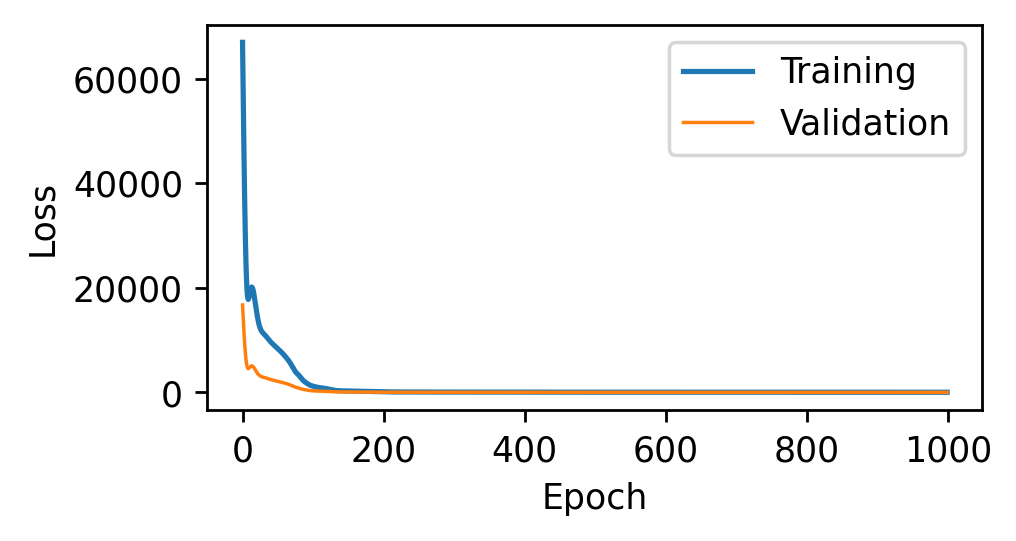

Epoch    0 of 1000:   Train Loss = 45731.4219   Validation Loss = 11518.2520
Epoch  100 of 1000:   Train Loss = 40.0644   Validation Loss = 10.5471
Epoch  200 of 1000:   Train Loss = 9.5774   Validation Loss = 2.4122
Epoch  300 of 1000:   Train Loss = 6.1848   Validation Loss = 1.5560
Epoch  400 of 1000:   Train Loss = 4.8787   Validation Loss = 1.2424
Epoch  500 of 1000:   Train Loss = 4.3093   Validation Loss = 1.0993
Epoch  600 of 1000:   Train Loss = 3.8496   Validation Loss = 0.9803
Epoch  700 of 1000:   Train Loss = 3.5116   Validation Loss = 0.8894
Epoch  800 of 1000:   Train Loss = 3.2589   Validation Loss = 0.8223
Epoch  900 of 1000:   Train Loss = 4.6705   Validation Loss = 1.1713


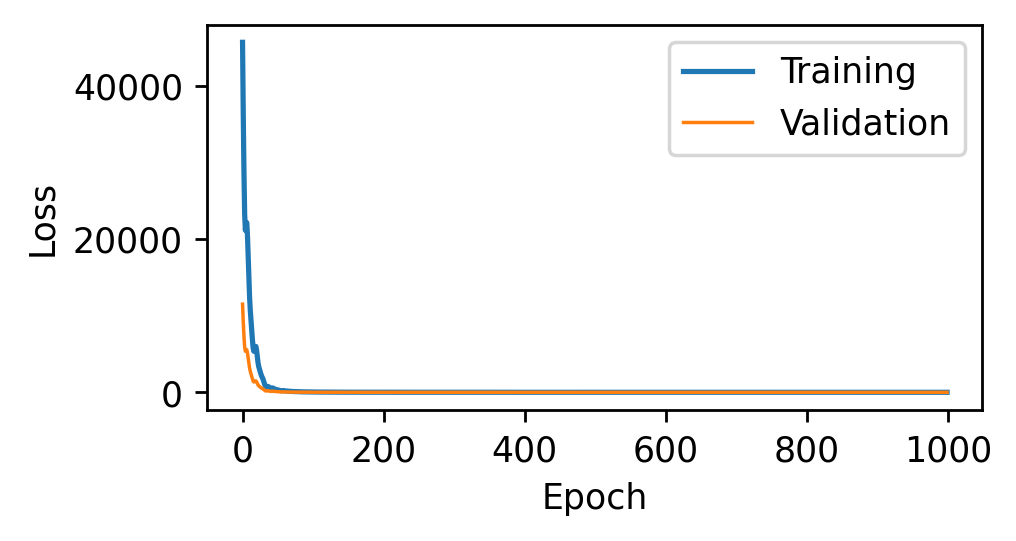

Epoch    0 of 1000:   Train Loss = 39570.2539   Validation Loss = 9996.0332
Epoch  100 of 1000:   Train Loss = 11.6366   Validation Loss = 3.0433
Epoch  200 of 1000:   Train Loss = 3.3677   Validation Loss = 0.8748
Epoch  300 of 1000:   Train Loss = 2.2195   Validation Loss = 0.5804
Epoch  400 of 1000:   Train Loss = 1.8316   Validation Loss = 0.4750
Epoch  500 of 1000:   Train Loss = 5.1670   Validation Loss = 1.2724
Epoch  600 of 1000:   Train Loss = 1.3733   Validation Loss = 0.3543
Epoch  700 of 1000:   Train Loss = 1.8989   Validation Loss = 0.4778
Epoch  800 of 1000:   Train Loss = 1.0687   Validation Loss = 0.2794
Epoch  900 of 1000:   Train Loss = 1.5309   Validation Loss = 0.3831


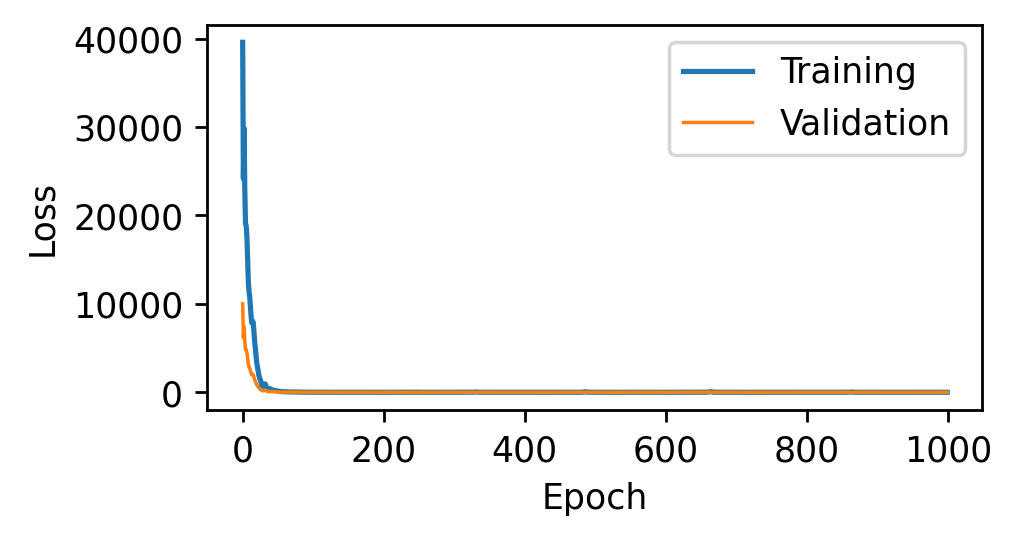

In [24]:
model1 = InverseArm(hidden_layer_sizes=[12], max_angle=None)
model2 = InverseArm(hidden_layer_sizes=[24,24], max_angle=None)
model3 = InverseArm(hidden_layer_sizes=[48,48,48], max_angle=None)

train(model1, X_train, X_val, lr=0.01, epochs=1000, gamma=0.995, create_plot=True)
train(model2, X_train, X_val, lr=0.01, epochs=1000, gamma=0.995, create_plot=True)
train(model3, X_train, X_val, lr=0.01, epochs=1000, gamma=0.995, create_plot=True)

## Visualizations

For each of your models, use the function `plot_predictions` to visualize model predictions on the domain. You should observe improvements with increasing network size.

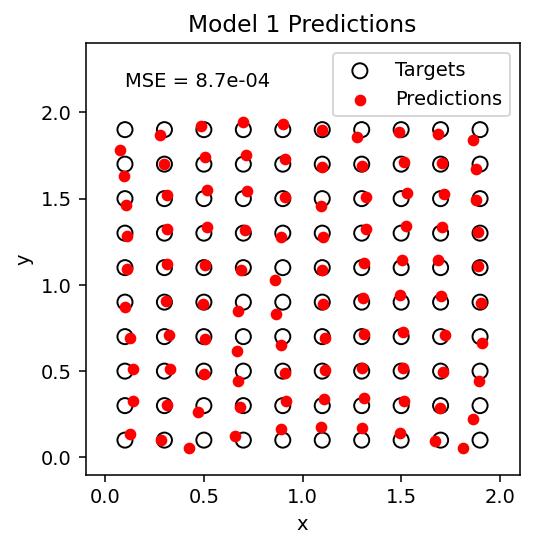

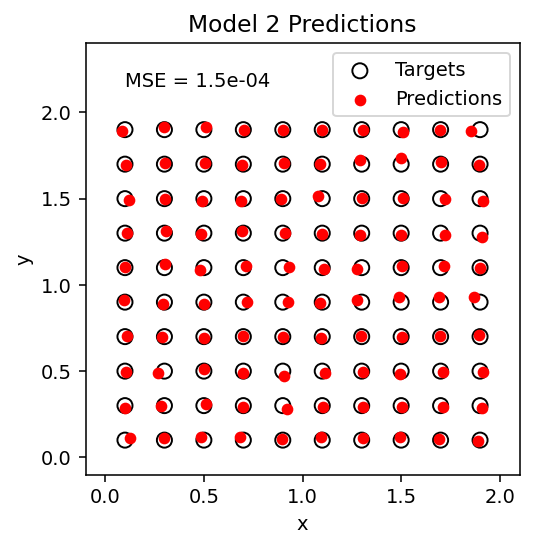

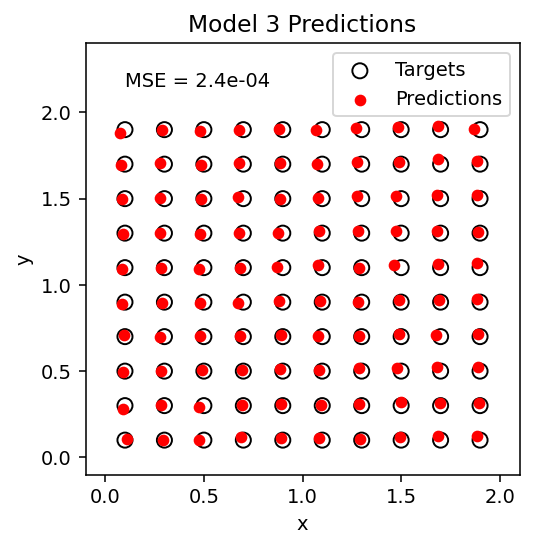

In [25]:
plot_predictions(model1, "Model 1 Predictions")
plot_predictions(model2, "Model 2 Predictions")
plot_predictions(model3, "Model 3 Predictions")

## Interactive Visualization


You can use the interactive plot below to look at the performance of your model. (The model used must be named `model`.)

In [26]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual, Layout, FloatSlider, Dropdown

def plot_inverse(x, y):
    xy = torch.Tensor([[x,y]])
    theta1, theta2, theta3 = model3(xy).detach().numpy().flatten().tolist()
    plot_arm(theta1, theta2, theta3, show=False)
    plt.scatter(x, y, s=100, c="red",zorder=1000,marker="x")
    plt.plot([0,2,2,0,0],[0,0,2,2,0],c="lightgray",linewidth=1,zorder=-1000)
    plt.show()

slider1 = FloatSlider(value=1, min=-.5, max=2.5, step=1/100, description='x', disabled=False, continuous_update=True, orientation='horizontal', readout=False, layout = Layout(width='550px'))
slider2 = FloatSlider(value=1, min=-.5, max=2.5, step=1/100, description='y', disabled=False, continuous_update=True, orientation='horizontal', readout=False, layout = Layout(width='550px'))

interactive_plot = interactive(plot_inverse, x = slider1, y = slider2)
output = interactive_plot.children[-1]
output.layout.height = '600px'

interactive_plot

interactive(children=(FloatSlider(value=1.0, description='x', layout=Layout(width='550px'), max=2.5, min=-0.5,…

## Training more neural networks

Now train more networks with the following details:
1. `hidden_layer_sizes=[48,48], max_angle=torch.pi/2`, train with `lr=0.01, epochs=1000, gamma=.995`
2. `hidden_layer_sizes=[48,48], max_angle=None`, train with `lr=1, epochs=1000, gamma=1`
3. `hidden_layer_sizes=[48,48], max_angle=2`, train with `lr=0.0001, epochs=300, gamma=1`

For each network, show a loss curve plot and a `plot_predictions` plot.

Epoch    0 of 1000:   Train Loss = 48762.4766   Validation Loss = 12261.9648
Epoch  100 of 1000:   Train Loss = 317.1681   Validation Loss = 83.0302
Epoch  200 of 1000:   Train Loss = 281.0048   Validation Loss = 73.5855
Epoch  300 of 1000:   Train Loss = 282.1428   Validation Loss = 73.7901
Epoch  400 of 1000:   Train Loss = 277.1550   Validation Loss = 72.5948
Epoch  500 of 1000:   Train Loss = 275.9739   Validation Loss = 72.3016
Epoch  600 of 1000:   Train Loss = 275.3608   Validation Loss = 72.1548
Epoch  700 of 1000:   Train Loss = 274.6807   Validation Loss = 71.9697
Epoch  800 of 1000:   Train Loss = 274.0745   Validation Loss = 71.8028
Epoch  900 of 1000:   Train Loss = 273.8226   Validation Loss = 71.7378


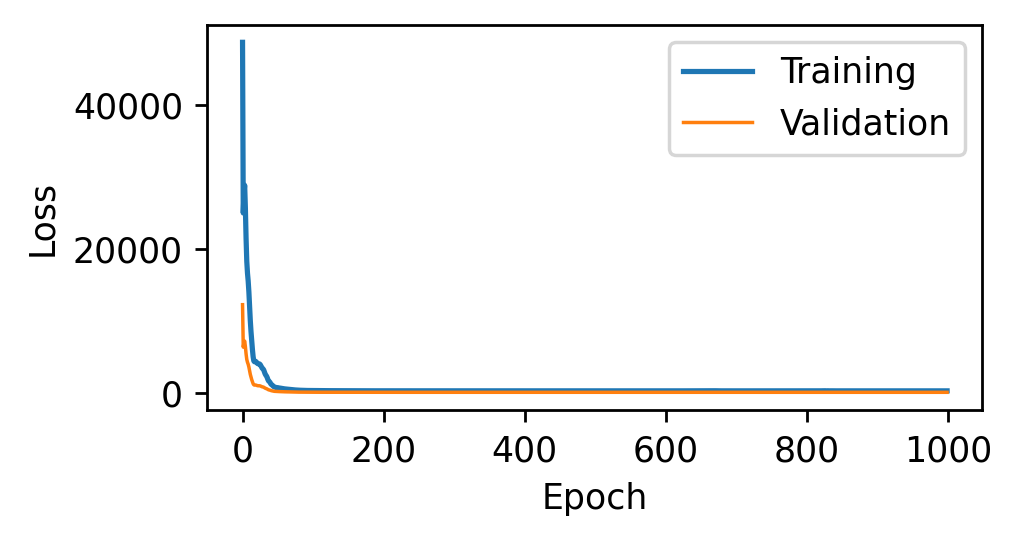

Epoch    0 of 1000:   Train Loss = 66801.4297   Validation Loss = 16693.6367
Epoch  100 of 1000:   Train Loss = 45625.3828   Validation Loss = 11200.3545
Epoch  200 of 1000:   Train Loss = 45746.8047   Validation Loss = 11268.9727
Epoch  300 of 1000:   Train Loss = 45463.8984   Validation Loss = 11303.8525
Epoch  400 of 1000:   Train Loss = 45094.6836   Validation Loss = 11689.4844
Epoch  500 of 1000:   Train Loss = 45410.0781   Validation Loss = 11405.5684
Epoch  600 of 1000:   Train Loss = 68907.2656   Validation Loss = 16660.7969
Epoch  700 of 1000:   Train Loss = 45602.3906   Validation Loss = 11045.7578
Epoch  800 of 1000:   Train Loss = 45727.5469   Validation Loss = 11548.3125
Epoch  900 of 1000:   Train Loss = 45721.9023   Validation Loss = 11121.7949


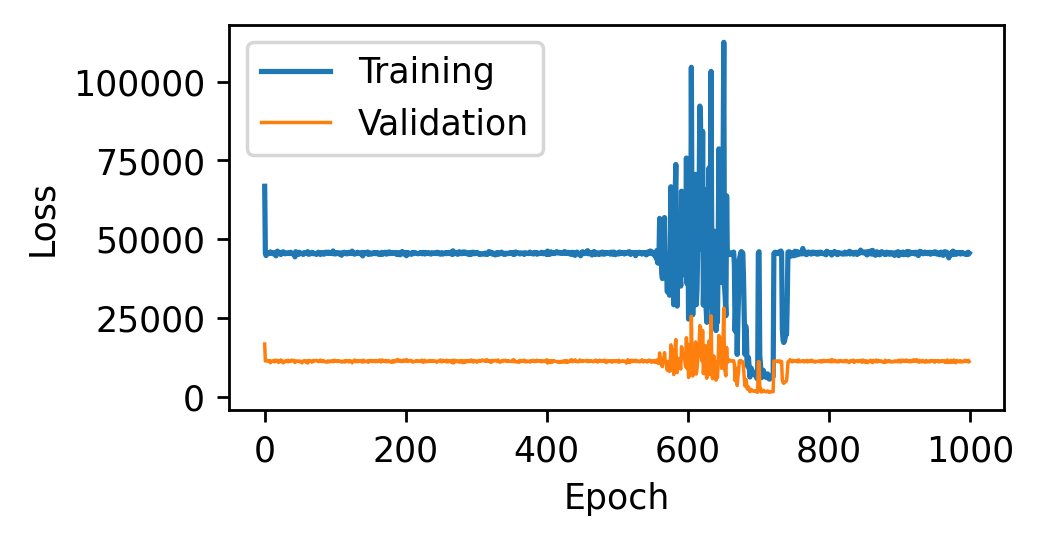

Epoch    0 of 300:   Train Loss = 74592.7109   Validation Loss = 18621.3730
Epoch   30 of 300:   Train Loss = 55391.0547   Validation Loss = 13910.5908
Epoch   60 of 300:   Train Loss = 40373.6875   Validation Loss = 10210.3701
Epoch   90 of 300:   Train Loss = 31063.5059   Validation Loss = 7894.8740
Epoch  120 of 300:   Train Loss = 26423.0547   Validation Loss = 6722.6460
Epoch  150 of 300:   Train Loss = 24076.2969   Validation Loss = 6115.4277
Epoch  180 of 300:   Train Loss = 22664.2617   Validation Loss = 5751.7046
Epoch  210 of 300:   Train Loss = 21114.8262   Validation Loss = 5360.3501
Epoch  240 of 300:   Train Loss = 19274.3633   Validation Loss = 4895.3457
Epoch  270 of 300:   Train Loss = 17261.7402   Validation Loss = 4387.6230


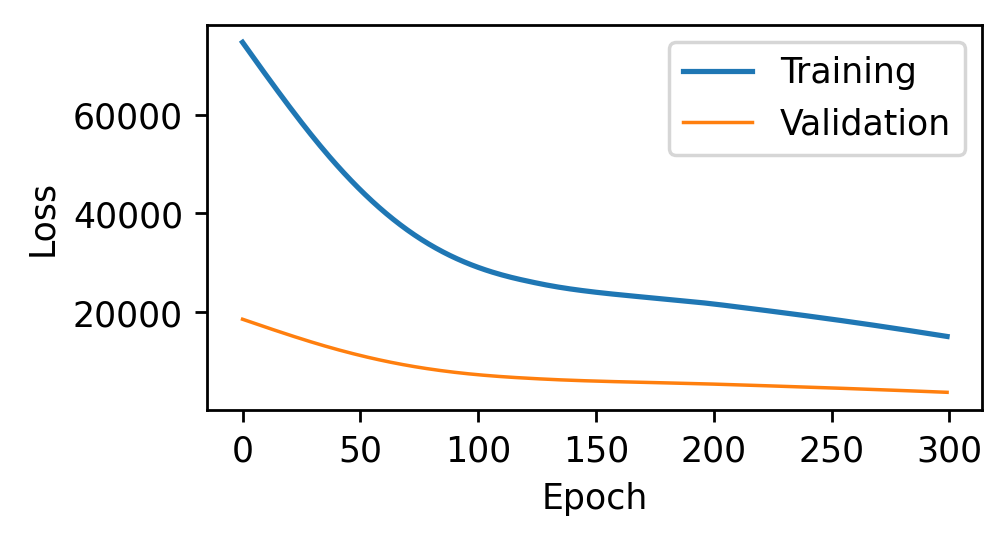

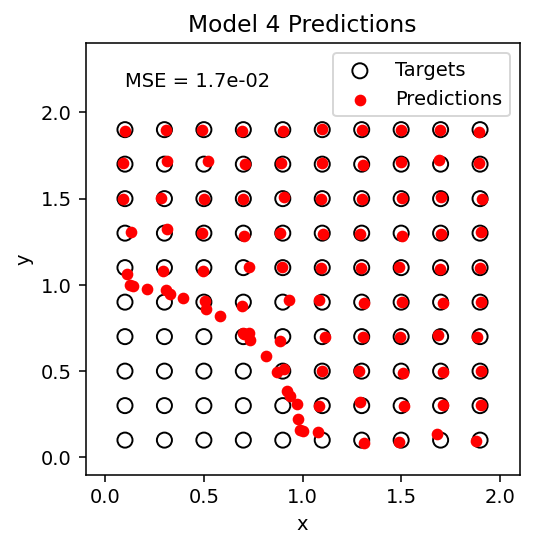

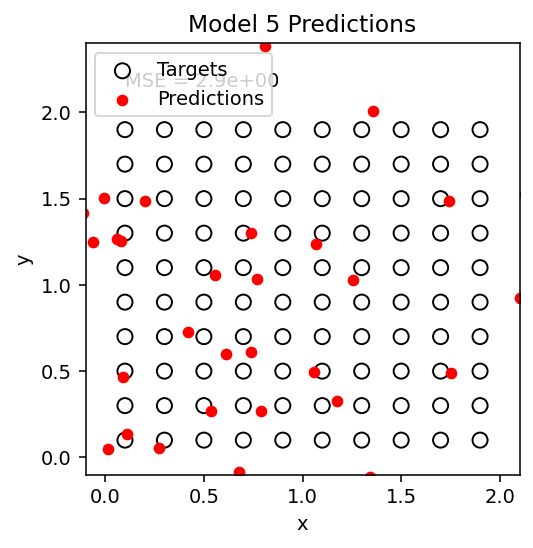

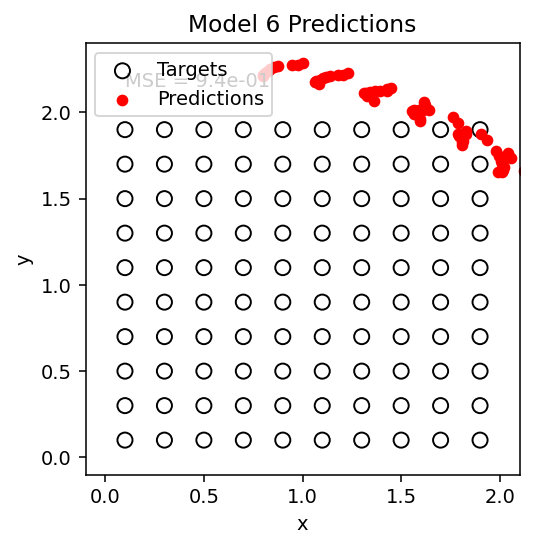

In [29]:
model4 = InverseArm(hidden_layer_sizes=[48,48], max_angle=torch.pi/2)
model5 = InverseArm(hidden_layer_sizes=[48,48], max_angle=None)
model6 = InverseArm(hidden_layer_sizes=[48,48], max_angle=2)

train(model4, X_train, X_val, lr=0.01, epochs=1000, gamma=0.995, create_plot=True)
train(model5, X_train, X_val, lr=1, epochs=1000, gamma=1, create_plot=True)
train(model6, X_train, X_val, lr=0.0001, epochs=300, gamma=1, create_plot=True)

plot_predictions(model4, "Model 4 Predictions")
plot_predictions(model5, "Model 5 Predictions")
plot_predictions(model6, "Model 6 Predictions")

## Prompts

None of these 3 models should have great performance.
Describe what went wrong in each case.

In the first model, it doesn't allow to predict across the whole range of joint angles to predict all the configuration.

In the second model, learning rate is to high leading to instability during the training.

In the third model, learning rate is to low while with limited epochs, the model was not fully trained to the data; Also it didn't allow to predict across the whole range of joint angles to predict all the configuration. 